In [2]:
import pandas as pd
import time
import numpy as np
from ClusteringPredictiveModel import ClusteringPredictiveModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from  matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from LastStateEncoder import LastStateEncoder
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
data=pd.read_csv('BPIC 2017 just complete cases.csv',sep=';')

In [4]:
n_clusters = 30

In [5]:
#global case_id_col,event_col,timestamp_col,label_col,pos_label,numeric_cols,meta_event_data,other_col,variant_col

case_id_col = "Case ID"
event_col = "Activity"
timestamp_col = ["Complete Timestamp"]
label_col = 'lbl'
pos_label = 'A_Pending'
cat_cols = ['Resource','(case) LoanGoal','(case) ApplicationType'] 
numeric_cols = [ '(case) RequestedAmount',label_col]  
meta_event_data=['Start Timestamp','EventOrigin','OfferID','Unnamed: 0','Transition','milli_seconds',
          'EventID','lifecycle:transition','days','D_seconds',
          'Accepted', 'Selected' ,
          'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms','outcome',
          'Variant', 'Action', 'CreditScore','OfferedAmount'
          ]
other_col= '(case) RequestedAmount'
variant_col='Variant index'

In [6]:
data.drop(meta_event_data,axis=1,inplace=True)
data.drop(variant_col,axis=1,inplace=True)

In [7]:
# divide into train and test data
np.random.seed(22)
sample_cases_KMeans = np.random.choice(data[case_id_col].unique(), len(data['Case ID'].unique()))
train_cases_KMeans, test_cases_KMeans = train_test_split(sample_cases_KMeans , train_size = 4.0/5, random_state = 22 )
train_KMeans = data[data[case_id_col].isin(train_cases_KMeans)]
test_KMeans = data[data[case_id_col].isin(test_cases_KMeans)]

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
# fit model (cluster traces and build classifier for each cluster)
model = ClusteringPredictiveModel(case_id_col, event_col, label_col, timestamp_col, cat_cols, numeric_cols, n_clusters=n_clusters, n_estimators=100, random_state=22, fillna=True)
model.fit(train_KMeans)

# this for cutting trace , you can skip to use complete traces

In [27]:
# trim first n activity
#######################

n=12
n_events=test_KMeans.groupby(['Case ID']).apply(lambda x: x.head(n)).droplevel(1)

In [120]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Submitted'

to_event  = 'A_Accepted'

from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='A_Create Application'].index
    idx2=dd[dd['Activity'].values==to_event].index 
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

In [121]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Accepted'

to_event  = 'O_Sent (mail and online)'

#from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index+1
    if not idx.any():
        idx=dd[dd['Activity'].values=='A_Create Application'].index+1
    idx2=dd[dd['Activity'].values==to_event].index 
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='O_Sent (online only)'].index
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='O_Created'].index
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

In [122]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Validating'

to_event  = 'A_Pending'

#from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='W_Call after offers'].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='W_Complete application'].index
        
    if not idx.any():
        idx=dd[dd['Activity'].values=='W_Shortened completion'].index    
    
    idx2=dd[dd['Activity'].values==to_event].index 
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='A_Denied'].index
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='A_Cancelled'].index
    if not (idx2.any()and idx.any()):
        continue
    if not idx2.any():
        idx2=[dd.index.max()]
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

# ============ end skip

In [9]:
def cut(x,n):
    if len(x)>n:
        return x.head(n)
    else:
        return;

In [12]:
def predict_outcome(test_KMedoide,n='all'):
    
    if n=='all':
        n_events=test_KMeans

    # trim first n activity
    #######################
    else:
        #n_events=test_KMedoide.groupby(['Case ID'],sort=False).apply(lambda x: x.head(n)).droplevel(0)
        n_events=test_KMeans.groupby(['Case ID'],sort=False).apply(lambda x: cut(x,n)).droplevel(0)
    tot=len(test_KMeans['Case ID'].unique())
    print("Prediction for ",len(n_events['Case ID'].unique()),'/',tot,' cases')

    # predict for test set (assign each trace to the closest cluster and predict outcome using the corresponding classifier)
    preds = model.predict_proba(n_events )


    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    th=dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i],th[i] = met.roc_curve(model.actual[model.actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(3):
        plt.figure()
        lw = i
        plt.plot(fpr[i], tpr[i], color='darkorange',
                 lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic %r' %model.actual.columns.values[i+1])
        plt.legend(loc="lower right")
        plt.show()
    return;

==================== prefix length =  8 ==========================
 0  3693 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  2013 0 0 0 0 0 0 0 0 0 0


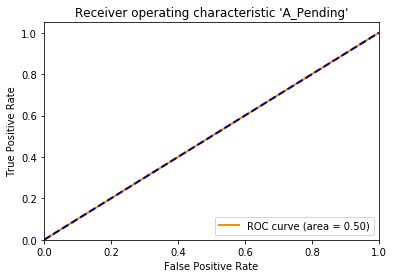

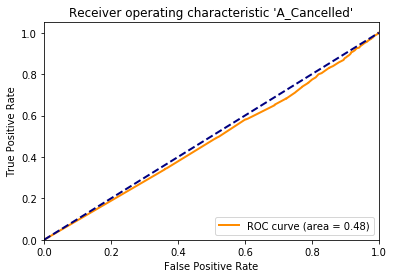

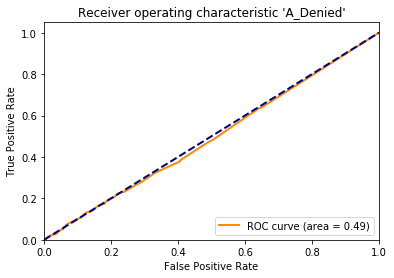

==================== prefix length =  12 ==========================
 0  1381 0 0 0 0 0  18  1185 0 0  2741 0 0 0 0 0 0 0  381 0 0 0 0 0 0 0 0 0 0


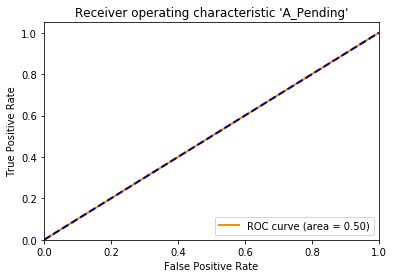

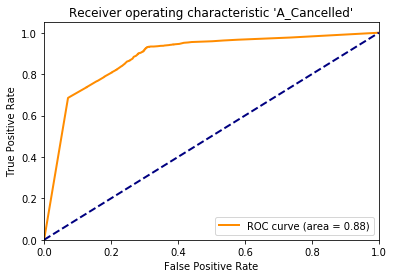

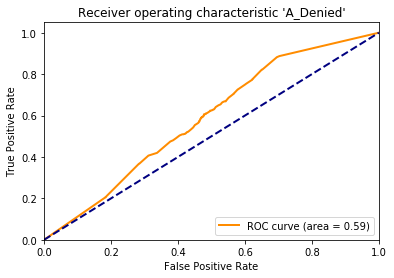

==================== prefix length =  16 ==========================
  979  964  1 0  332 0 0  240  362 0  326  332  45 0 0 0 0  702  619  372 0  8  306 0 0 0 0  118 0 0


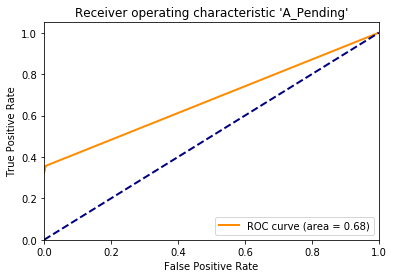

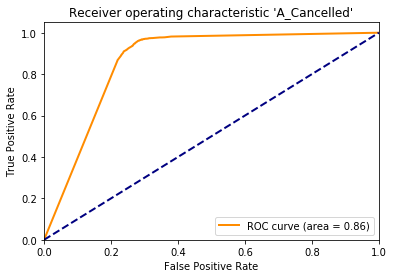

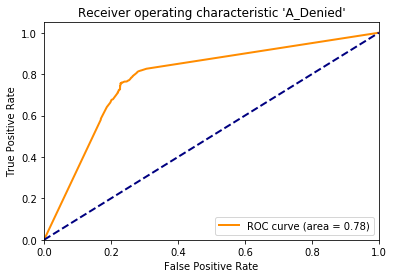

==================== prefix length =  20 ==========================
  101  962  311 0  332 0  337  53  347 0  357  318  119  390  129  34  177  213  115  371 0  75  306  254 0  162 0  243 0 0


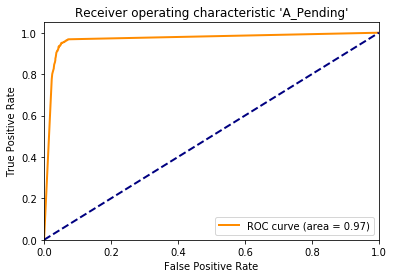

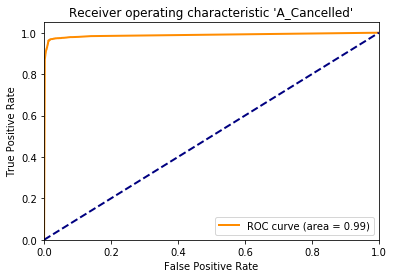

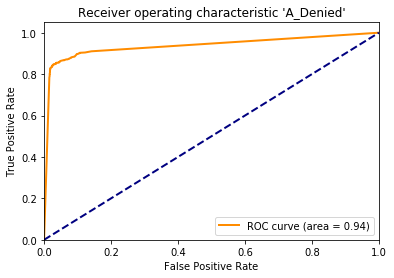

==================== prefix length =  24 ==========================
  108  962  311  79  332 0  210  31  346  176  357  317  123  392  151  246  115  171  102  371 0  70  306  177 0  91 0  122  7  33


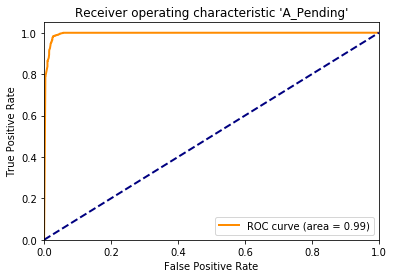

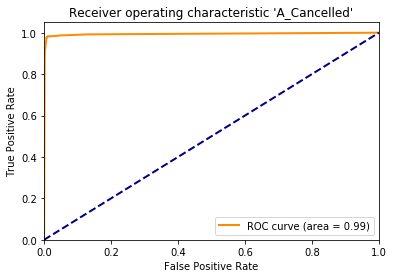

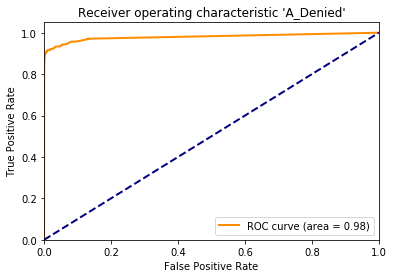

==================== prefix length =  all ==========================
  108  962  311  56  332  54  207  31  346  126  357  317  123  392  86  197  111  172  102  371  5  38  306  177  15  91  72  122  42  77


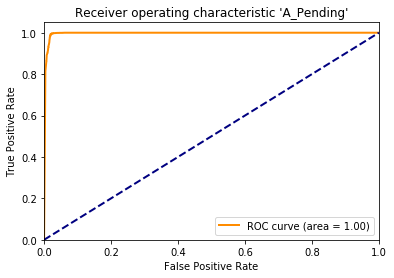

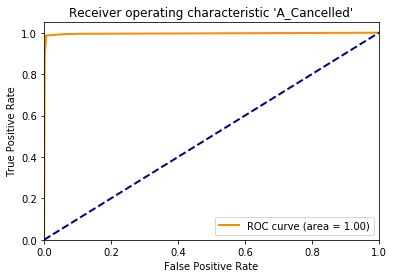

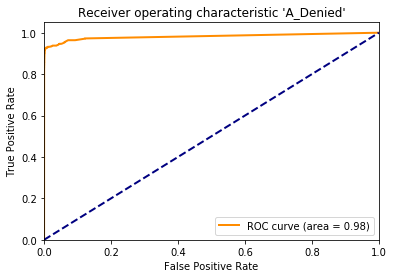

In [11]:
# 30 clusters
# all traces
for prefix in list([8,12,16,20,24,'all']):
    print('==================== prefix length = ',prefix,'==========================')
    predict_outcome(test_KMeans,n=prefix)

==================== prefix length =  8 ==========================
Prediction for  5692 / 5706  cases
 0  3681 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  2011 0 0 0 0 0 0 0 0 0 0


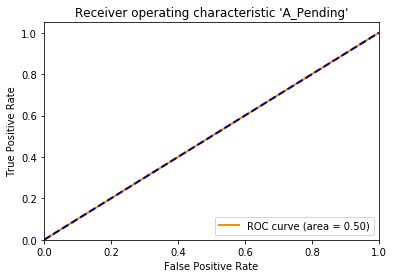

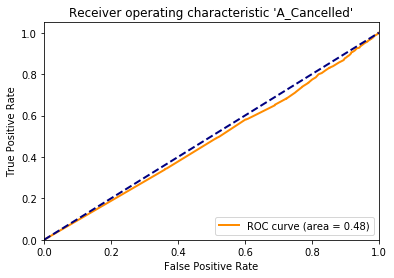

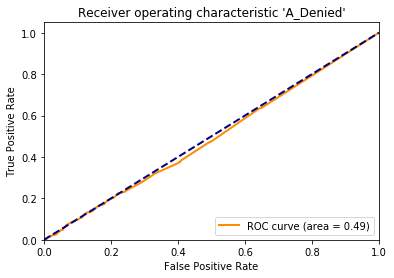

==================== prefix length =  12 ==========================
Prediction for  4380 / 5706  cases
 0  427 0 0 0 0 0  18  1183 0 0  2740 0 0 0 0 0 0 0  12 0 0 0 0 0 0 0 0 0 0


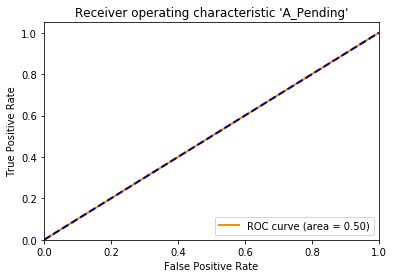

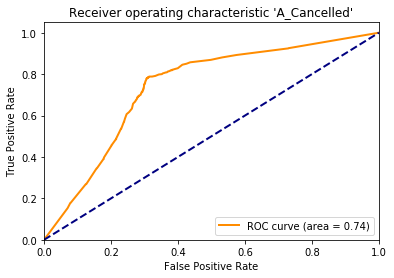

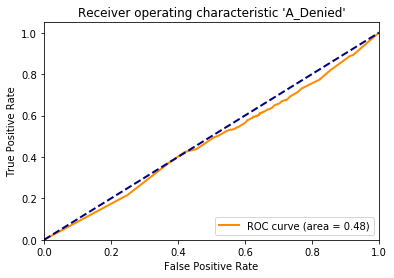

==================== prefix length =  16 ==========================
Prediction for  2839 / 5706  cases
  905  2 0 0 0 0 0  235  19 0  187  21  43 0 0 0 0  700  598  1 0  8  2 0 0 0 0  118 0 0


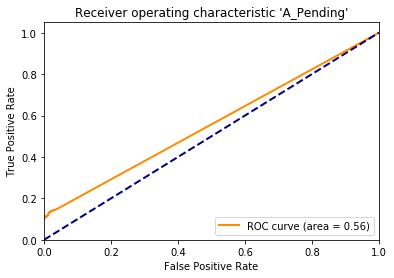

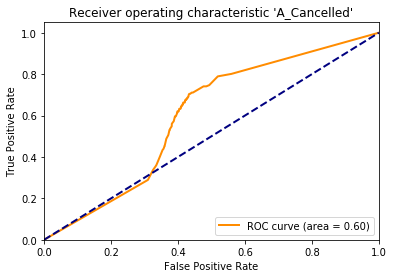

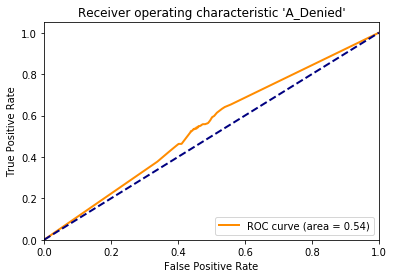

==================== prefix length =  20 ==========================
Prediction for  1343 / 5706  cases
  1 0 0 0 0 0  332  22  1 0 0  1  3  6  123  34  177  71  21 0 0  64 0  186 0  162 0  139 0 0


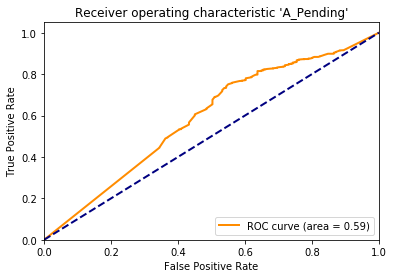

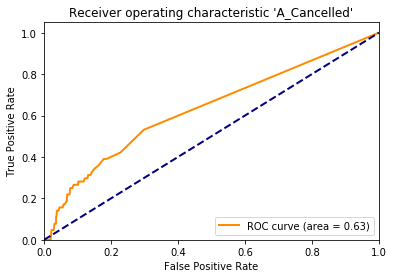

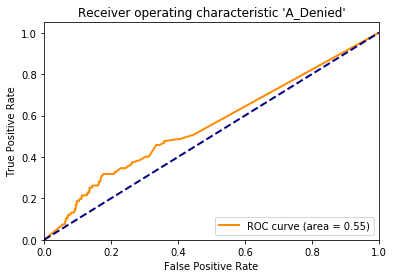

==================== prefix length =  24 ==========================
Prediction for  587 / 5706  cases
 0 0 0  70 0 0  4 0 0  150 0 0 0  1  98  176  5 0 0 0 0  42 0  1 0 0 0 0  7  33


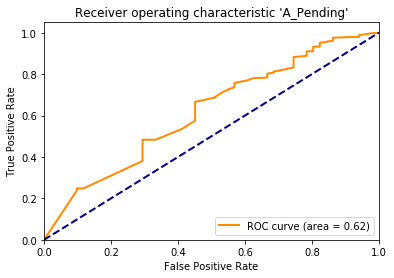

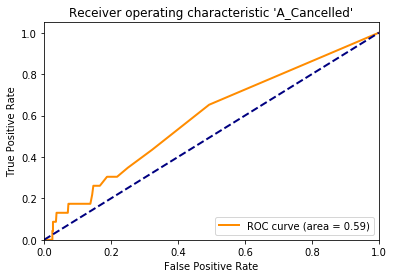

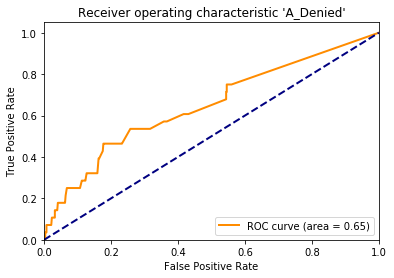

==================== prefix length =  all ==========================
Prediction for  5706 / 5706  cases
  108  962  311  56  332  54  207  31  346  126  357  317  123  392  86  197  111  172  102  371  5  38  306  177  15  91  72  122  42  77


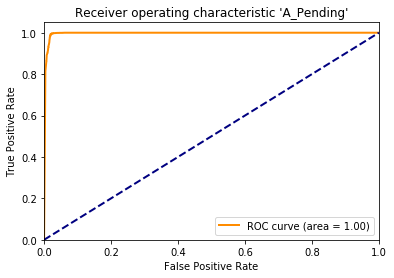

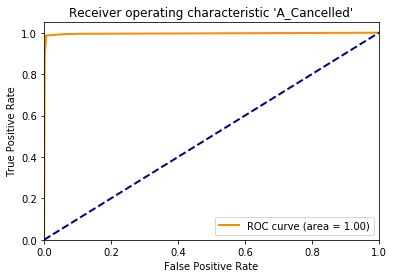

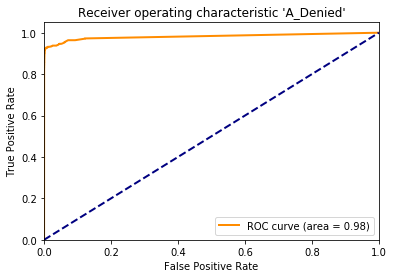

In [13]:
# 30 clusters
# failure cases excluded
for prefix in list([8,12,16,20,24,'all']):
    print('==================== prefix length = ',prefix,'==========================')
    predict_outcome(test_KMeans,n=prefix)

# End,

In [39]:
model.actual[0:1]

,Case ID,A_Cancelled,A_Denied,A_Pending
0,Application_821425679,0,0,1


In [40]:
preds[0:1]

,Case ID,A_Cancelled,A_Denied,A_Pending
0,Application_1004303396,0.0,0.0,1.0


In [55]:
h='A_Denied'
uc=test_KMeans[test_KMeans['lbl']==h]['Case ID'].unique()
AD=test_KMeans[test_KMeans['Case ID'].isin(uc)][0:230]
h='A_Cancelled'
uc=test_KMeans[test_KMeans['lbl']==h]['Case ID'].unique()
AC=test_KMeans[test_KMeans['Case ID'].isin(uc)][0:230]
h='A_Pending'
uc=test_KMeans[test_KMeans['lbl']==h]['Case ID'].unique()
AP=test_KMeans[test_KMeans['Case ID'].isin(uc)][0:230]
AC=pd.concat([AC,AP],axis=0)
AC=pd.concat([AC,AD],axis=0)

In [57]:
test_KMeans=AC

In [59]:
test_cases_KMeans=test_KMeans['Case ID'].unique()

In [127]:
test_KMeans.shape

(690, 6)